In [99]:
from bigbang.archive import Archive
from config.config import CONFIG
import bigbang.domain as domain
import os
import pandas as pd
import re

## Load many mailing list archives

For this study, we will start with the archives of many mailing lists.

Conceptually, we can run this analysis for the entirety of IETF, for example.

In [70]:
number = r"^[0-9]"

In [71]:
arxs = {}

for file in os.listdir(CONFIG.mail_path):
    if file.endswith(".csv") and not re.match(number, file):
        name = file[:-4]
        try:
            arxs[name] = Archive(name)
        except Exception as e:
            print(name + ": " + str(e))

carddav: 'Archive after initial processing is empty. Was data collected properly?'
CCAMP: 'Archive after initial processing is empty. Was data collected properly?'
dea-dir: 'Archive after initial processing is empty. Was data collected properly?'
aulli: 'Archive after initial processing is empty. Was data collected properly?'
dlswmib: 'Archive after initial processing is empty. Was data collected properly?'
deltav: 'Archive after initial processing is empty. Was data collected properly?'
dasl: 'Archive after initial processing is empty. Was data collected properly?'
smime: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

dns-security: 'Archive after initial processing is empty. Was data collected properly?'


In [72]:
print("Total number of Archives: " + str(len(arxs)))

Total number of Archives: 191


Collect information about the senders from each mailing list.

In [100]:
def senders(arx):
    emails = arx.data['From'].apply(domain.extract_email)
    domains = arx.data['From'].apply(domain.extract_domain)
    froms = pd.concat([arx.data['From'], emails, domains], axis=1, keys=['From','email','domain'])
    
    return froms

In [101]:
wg_senders = {wg : senders(arxs[wg]) for wg in arxs}

## Global analysis

We are going to start with using statistics from the global corpus of data. To combine the data from each working group into one DataFrame.

In [102]:
all_senders = pd.concat([wg_senders[wg] for wg in wg_senders])

In [104]:
print(all_senders.shape)

(514331, 3)


We are interested in know which email domains are significant. Those domains that are used by more than one email address in a significant way are more informative about a corporation or organization's involvement in IETF. We therefor use the _domain entropy_ metric, discussed in the "Using Domain Entropy to Identify Organizations" notebook.

**TODO**: This is repeated code; it should be moved to the library.

In [105]:
import math

froms = all_senders

def domain_entropy(domain):
    domain_messages = froms[froms['domain'] == domain]
    
    n_D = domain_messages.shape[0]
    
    entropy = 0
    
    emails = domain_messages['email'].unique()
    
    for em in emails:
        em_messages = domain_messages[domain_messages['email'] == em]
        n_e = em_messages.shape[0]
        
        p_em = float(n_e) / n_D
        
        entropy = entropy - p_em * math.log(p_em)
        
    return entropy

domains = froms['domain'].unique()
domain_entropies = pd.Series(index= domains, data = [domain_entropy(domain) for domain in domains])
domain_entropies = domain_entropies.sort_values(ascending=False)

This threshold is set very low. But it still is reducing the number of domains in the data set to ~10% of the original. Almost 90% of all email domains are associated with only one email address. We remove these from the study.

In [120]:
top_domains_series = domain_entropies[domain_entropies > .75]

In [121]:
des = domain_entropies.size
tds = top_domains_series.size

print(tds)
print(des)
print((tds) / des )

1212
22552
0.0537424618659099


In [122]:
top_domains = top_domains_series.index.values

In [123]:
wg = 'httpbisa'
wg_senders[wg][wg_senders[wg]['domain'].apply(lambda d: d in top_domains)].head()

,From,email,domain
Message-ID,,,
<20020412162821.GA21015@w3.org>,Gerald Oskoboiny <gerald@w3.org>,gerald@w3.org,w3.org
<009901c1e5b5$07513b90$71432099@larrypad>,"""Larry Masinter"" <LMM@acm.org>",LMM@acm.org,acm.org
<20020423124259.Y20848@www.markbaker.ca>,Mark Baker <distobj@acm.org>,distobj@acm.org,acm.org
<62E4D97E-57BF-11D6-87D7-000393753936@apache.org>,"""Roy T. Fielding"" <fielding@apache.org>",fielding@apache.org,apache.org
<79107D208BA38C45A4E45F62673A434D07371BCD@red-msg-07.redmond.corp.microsoft.com>,"""Henrik Frystyk Nielsen"" <henrikn@microsoft.com>",henrikn@microsoft.com,microsoft.com


We restrict the data to these domains for all mailing lists.

In [124]:
wg_senders_top_domains = {
    wg : wg_senders[wg][wg_senders[wg]['domain'].apply(lambda d: d in top_domains)]
    for wg in wg_senders}

## Organizational Involvement as a Working Group Feature

We have now narrowed the working group data down to counts of messages sent from ~1,000 significant domain names. Many of these domain names represent prominent companies that are involved in standard-setting.

In order to compare working groups based on the involvement of different organizations within them, we will begin to preprocess this data into a "feature vector" for each working group.

The feature vector for a working group will, for each domain, be the frequency (count) of domain in the working group, normalized by (divided by) the total frequency of the domain across all working groups. This is similar to the TF-IDF metric in natural language processing.

In [125]:
wg_top_domains_counts = {
    wg : wg_senders_top_domains[wg]['domain'].value_counts()
    for wg in wg_senders_top_domains
}

In [126]:
data = pd.concat(
    [wg_top_domains_counts[wg].rename(wg) 
    for wg in wg_top_domains_counts],
    axis=1).transpose().fillna(0)

In [127]:
data.head()

,ietf.org,comcast.net,amazon.com,irtf.org,gmail.com,irs.gov,facebookmail.com,eircom.net,yahoo.com,mail.com,...,billmail.scconsult.com,spamresource.com,squid-cache.org,maebashi-it.org,neonsys.com,hplb.hpl.hp.com,mefound.com,amh.auracom.com,usinternet.com,mail.lt
cdi,1858.0,101.0,40.0,39.0,35.0,15.0,14.0,11.0,10.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ecrit,407.0,6.0,0.0,0.0,313.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cin,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bess,822.0,0.0,0.0,0.0,774.0,0.0,0.0,0.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dhcipv6,289.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,36.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
norm_data = data.divide(data.sum())
norm_data.head()

,ietf.org,comcast.net,amazon.com,irtf.org,gmail.com,irs.gov,facebookmail.com,eircom.net,yahoo.com,mail.com,...,billmail.scconsult.com,spamresource.com,squid-cache.org,maebashi-it.org,neonsys.com,hplb.hpl.hp.com,mefound.com,amh.auracom.com,usinternet.com,mail.lt
cdi,0.065596,0.074704,0.08,0.371429,0.000865,0.132743,0.155556,0.207547,0.005230,0.051613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ecrit,0.014369,0.004438,0.00,0.000000,0.007734,0.000000,0.000000,0.000000,0.002615,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cin,0.000000,0.000000,0.00,0.000000,0.000124,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bess,0.029020,0.000000,0.00,0.000000,0.019124,0.000000,0.000000,0.000000,0.005230,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dhcipv6,0.010203,0.000000,0.00,0.000000,0.000000,0.008850,0.000000,0.000000,0.018828,0.045161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
norm2_data = norm_data.transpose().div(norm_data.sum(axis=1)).transpose().fillna(0)
norm2_data.shape

(191, 1212)

## Multi-dimensional scaling

Multidimensional scaling is a way of projecting multidimensional data into a lower dimensional space.

We will use multidimensional scaling to show the organizational composition (by domain) of different working groups, including their similarity and differences.

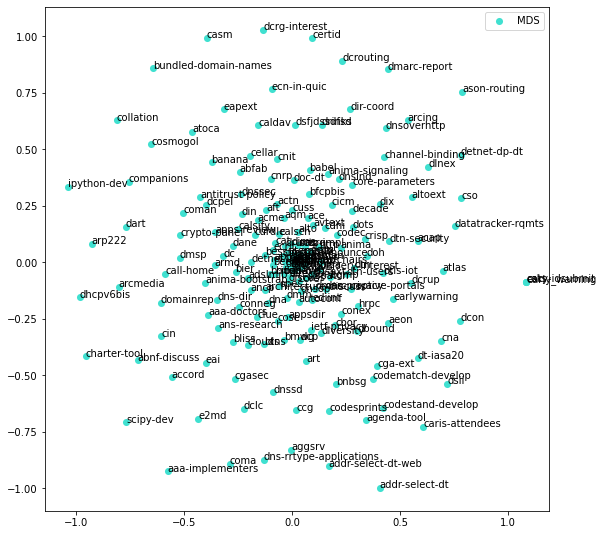

In [130]:
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

from sklearn import manifold
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

X_true = norm2_data.values

similarities = euclidean_distances(X_true)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9,
                   dissimilarity="precomputed", n_jobs=1)
pos = mds.fit(similarities).embedding_

# Rescale the data
pos *= np.sqrt((X_true ** 2).sum()) / np.sqrt((pos ** 2).sum())

# Rotate the data
clf = PCA(n_components=2)
X_true = clf.fit_transform(X_true)

pos = clf.fit_transform(pos)

fig = plt.figure(1, figsize=(7,7))
ax = plt.axes([0., 0., 1., 1.])

s = 50
plt.scatter(pos[:, 0], pos[:, 1], color='turquoise', s=s, lw=0, label='MDS')

for i, wg in enumerate(norm_data.index):
    plt.text(pos[i,0],pos[i,1], wg) #, fontsize = 'x-small')

plt.legend(scatterpoints=1, loc='best', shadow=False)

#similarities = similarities.max() / (similarities + EPSILON) * 100
#np.fill_diagonal(similarities, 0)
# Plot the edges
#start_idx, end_idx = np.where(pos)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
#segments = [[X_true[i, :], X_true[j, :]]
#            for i in range(len(pos)) for j in range(len(pos))]
#values = np.abs(similarities)
#lc = LineCollection(segments,
#                    zorder=0, cmap=plt.cm.Blues,
#                    norm=plt.Normalize(0, values.max()))
#lc.set_array(similarities.flatten())
#lc.set_linewidths(np.full(len(segments), 0.5))
#ax.add_collection(lc)

#plt.show()

In [131]:
clf = PCA(n_components=15)
clf.fit_transform(norm2_data.values)

print(clf.explained_variance_)

components = pd.DataFrame(clf.components_, columns = norm2_data.columns)

[0.01557659 0.00897712 0.00801418 0.00695594 0.00677802 0.00607324
 0.00549058 0.0054485  0.00528435 0.00514923 0.00510624 0.0050693
 0.005059   0.00498898 0.00485477]


In [132]:
for ix in components.index:
    print(f"Component {ix}")
    print("----->Top domains")
    print(components.loc[ix].sort_values(ascending=False)[:6])
    print("----->Bottom domains")
    print(components.loc[ix].sort_values()[:6])
    print("")

Component 0
----->Top domains
ietf.org            0.996883
comcast.net         0.011780
gmx.net             0.010319
SOS4HELP.COM       -0.000033
corazonevents.nl   -0.000033
hatc.com.sg        -0.000033
Name: 0, dtype: float64
----->Bottom domains
lacnic.net   -0.029082
isoc.org     -0.028155
avaya.com    -0.018727
icann.org    -0.015575
amsl.com     -0.014942
huawei.com   -0.014631
Name: 0, dtype: float64

Component 1
----->Top domains
lacnic.net    0.758783
isoc.org      0.562672
amsl.com      0.172491
icann.org     0.081464
it.uc3m.es    0.060561
emc.com       0.055754
Name: 1, dtype: float64
----->Bottom domains
gmx.net        -0.183277
avaya.com      -0.075002
huawei.com     -0.054400
broadcom.com   -0.050312
cisco.com      -0.033978
iana.org       -0.032882
Name: 1, dtype: float64

Component 2
----->Top domains
gmx.net          0.958279
lacnic.net       0.144443
cisco.com        0.118414
isoc.org         0.086454
microsoft.com    0.050747
mit.edu          0.039785
Name: 2, dtype

In [133]:
norm2_data

,ietf.org,comcast.net,amazon.com,irtf.org,gmail.com,irs.gov,facebookmail.com,eircom.net,yahoo.com,mail.com,...,billmail.scconsult.com,spamresource.com,squid-cache.org,maebashi-it.org,neonsys.com,hplb.hpl.hp.com,mefound.com,amh.auracom.com,usinternet.com,mail.lt
cdi,0.006546,0.007455,0.007983,0.037065,0.000086,0.013247,0.015523,0.020711,0.000522,0.00515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ecrit,0.001223,0.000378,0.000000,0.000000,0.000658,0.000000,0.000000,0.000000,0.000223,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cin,0.000000,0.000000,0.000000,0.000000,0.012509,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bess,0.004984,0.000000,0.000000,0.000000,0.003285,0.000000,0.000000,0.000000,0.000898,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dhcipv6,0.000917,0.000000,0.000000,0.000000,0.000000,0.000796,0.000000,0.000000,0.001693,0.00406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
dc,0.000101,0.001056,0.000000,0.000000,0.002823,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dnsoverhttp,0.000277,0.000000,0.000000,0.000000,0.006972,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dnssd,0.007473,0.000000,0.000000,0.000000,0.006410,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dir-coord,0.001097,0.000000,0.000000,0.000000,0.008447,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
